## Module 6 Project: First steps into Image-based Classification of Sediments in Drill Cores 

### Sebastian Schaller & Patricio Becerra

References:
- DiMartino et al. [2023]: https://doi.org/10.1038/s41598-023-47546-2  
- Multiclass semantic segmentation using U-Net Tutorial: https://www.youtube.com/watch?v=XyX5HNuv-xE

In [1]:
"""
Original code author: Dr. Sreenivas Bhattiprolu

Multiclass semantic segmentation using U-Net
Including segmenting large images by dividing them into smaller patches 
and stiching them back

Project-specific modifications by: Sebastian Schaller & Patricio Becerra 
"""

from simple_multi_unet_model import multi_unet_model #Uses softmax 

#!pip install --upgrade keras-cv tensorflow
#!pip install --upgrade keras
#!pip install --upgrade keras-cv-nightly tf-nightly
#!pip install opencv-python

from keras.utils import normalize
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!
import tensorflow as tf
import keras_cv
import keras
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

2025-07-31 17:49:16.942906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# set up the working directory to the chosen directory (raw string input), i.e., where the dataset is located
abs_path_loading_images=r'/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/training/images_small'
abs_path_loading_masks=r'/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/training/masks_small'
abs_path_save_model = r'/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/z_tryout'

In [4]:
#Resizing images, if needed
SIZE_X = 352 
SIZE_Y = 352
n_classes=5 #Number of classes for segmentation

In [5]:
# Set the working directory to the location of the processed images
os.chdir(abs_path_loading_images)

# Print the current working directory to verify that it's set to the desired location.
print(os.getcwd())

# List all jpg files in the current working directory.
files_dir = sorted([file for file in os.listdir(os.getcwd()) if file.endswith('.png')])

# Quality control: Print the list of files and directories in the current working directory
print(files_dir)

/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/training/images_small
['BASA1_003_1_A_0.png', 'BASA1_003_1_A_1.png', 'BASA1_003_1_A_2.png', 'BASA1_003_1_A_3.png', 'BASA1_003_1_A_4.png', 'BASA1_003_1_A_5.png', 'BASA1_003_1_A_6.png', 'BASA1_003_1_A_7.png', 'BASA1_003_1_A_8.png', 'BASA1_005_1_A_0.png', 'BASA1_005_1_A_1.png', 'BASA1_005_1_A_2.png', 'BASA1_005_1_A_3.png', 'BASA1_005_1_A_4.png', 'BASA1_005_1_A_5.png', 'BASA1_005_1_A_6.png', 'BASA1_005_1_A_7.png', 'BASA1_005_1_A_8.png', 'BASA1_009_1_A_0.png', 'BASA1_009_1_A_1.png', 'BASA1_009_1_A_2.png', 'BASA1_009_1_A_3.png', 'BASA1_009_1_A_4.png', 'BASA1_009_1_A_5.png', 'BASA1_009_1_A_6.png', 'BASA1_009_1_A_7.png', 'BASA1_009_1_A_8.png', 'BASA1_017_1_A_0.png', 'BASA1_017_1_A_1.png', 'BASA1_017_1_A_2.png', 'BASA1_017_1_A_3.png', 'BASA1_017_1_A_4.png', 'BASA1_017_1_A_5.png', 'BASA1_017_1_A_6.png', 'BASA1_017_1_A_7.png', 'BASA1_017_1_A_8.png', 'BASA1_021_1_A_0.png', 'BASA1_021_1_A_1.png', 'BASA1_021_1_A_2.png', 'BASA1_021_1_A_3.png',

In [6]:
# Initialize a zeroes list to store loaded images
image_loaded = [0] * len(files_dir)

# Quality control: Print the initialized list
#print(image_loaded)

# Iterate over the list of file names
for i in range(len(image_loaded)):
    # Load an image from a file specified by the file directory
    image = io.imread(files_dir[i])
    # 'io.imread' reads an image from the specified file path and returns it as an ndarray.
    
    # Quality control: Print the shape of the loaded image
    #print(image.shape)
    
    # Store the loaded image in the list of loaded images
    image_loaded[i] = image

# Convert the list of loaded images to a NumPy array
train_images = np.array(image_loaded)

### Capture training image info as a list
train_images = []

for directory_path in glob.glob(r"C:\Users\User\Desktop\test\pictures_smal"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
### Convert list to array for machine learning processing        
train_images = np.array(train_images)

### Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(r"C:\Users\User\Desktop\test\masks_small"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
### Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
# Set the working directory to the location of the processed image masks
os.chdir(abs_path_loading_masks)

# Print the current working directory to verify that it's set to the desired location.
print(os.getcwd())

# List all .tif files in the current working directory
files_dir = sorted([file for file in os.listdir(os.getcwd()) if file.endswith('.tif')])

# Quality control: Print the list of files and directories in the current working directory
print(files_dir)

# Initialize a list to store loaded masks
mask_loaded = [0] * len(files_dir)

# Quality control: Print the initialized list
print(mask_loaded)

# Iterate over the list of file names
for i in range(len(mask_loaded)):
    # Load a mask image from a file specified by the file directory
    mask = io.imread(files_dir[i])
    
    # Print the shape of the loaded mask image
    print(mask.shape)
    
    # Store the loaded mask image in the list of loaded masks
    mask_loaded[i] = mask
    
    # Print the index of the current mask being processed
    print(i)

# Convert the list of loaded masks to a NumPy array
train_masks = np.array(mask_loaded)

# Print the shape of the NumPy array of loaded masks
print(train_masks.shape)

# Count unique values in the loaded mask array and print the results
print(np.unique(train_masks, return_counts=True))

/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/training/masks_small
['BASA1_003_1_A_0_mask.tif', 'BASA1_003_1_A_1_mask.tif', 'BASA1_003_1_A_2_mask.tif', 'BASA1_003_1_A_3_mask.tif', 'BASA1_003_1_A_4_mask.tif', 'BASA1_003_1_A_5_mask.tif', 'BASA1_003_1_A_6_mask.tif', 'BASA1_003_1_A_7_mask.tif', 'BASA1_003_1_A_8_mask.tif', 'BASA1_005_1_A_0_mask.tif', 'BASA1_005_1_A_1_mask.tif', 'BASA1_005_1_A_2_mask.tif', 'BASA1_005_1_A_3_mask.tif', 'BASA1_005_1_A_4_mask.tif', 'BASA1_005_1_A_5_mask.tif', 'BASA1_005_1_A_6_mask.tif', 'BASA1_005_1_A_7_mask.tif', 'BASA1_005_1_A_8_mask.tif', 'BASA1_009_1_A_0_mask.tif', 'BASA1_009_1_A_1_mask.tif', 'BASA1_009_1_A_2_mask.tif', 'BASA1_009_1_A_3_mask.tif', 'BASA1_009_1_A_4_mask.tif', 'BASA1_009_1_A_5_mask.tif', 'BASA1_009_1_A_6_mask.tif', 'BASA1_009_1_A_7_mask.tif', 'BASA1_009_1_A_8_mask.tif', 'BASA1_017_1_A_0_mask.tif', 'BASA1_017_1_A_1_mask.tif', 'BASA1_017_1_A_2_mask.tif', 'BASA1_017_1_A_3_mask.tif', 'BASA1_017_1_A_4_mask.tif', 'BASA1_017_1_A_5_mask.ti

In [8]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape

# Import necessary library
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder object
labelencoder = LabelEncoder()

# Get the shape of the training masks array
n, h, w = train_masks.shape

# Flattening: Reshape the 3D array into a one-column 2D array, then flatten it to a 1D array.
train_masks_reshaped = train_masks.reshape(-1, 1).flatten()

# Print the shape of the flattened array
print(train_masks_reshaped.shape)

# Encode the flattened array of training masks using LabelEncoder
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
# 'fit_transform' fits the LabelEncoder to the data and transforms it, encoding each unique value with a unique integer.

# Reshape the encoded array back to its original shape
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
# Reshape the 1D encoded array back to the original 3D shape.

# Print the shape of the encoded array
print(train_masks_reshaped_encoded.shape)

# Print the unique values in the encoded array
print(np.unique(train_masks_encoded_original_shape))
# Print the unique values in the array to check the encoding.

(83263488,)
(83263488,)
[0 1 2 3 4]


In [9]:
print(train_images.shape,train_images.ndim)
print(train_masks.shape,train_masks.ndim)


(672, 352, 352) 3
(672, 352, 352) 3


In [10]:
#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)
print(train_masks_input.shape,train_masks_input.ndim)

print(train_images.shape,train_images.ndim)

(672, 352, 352, 1) 4
(672, 352, 352, 1) 4


In [11]:
### Assigning automatically selected training and testing datasets for model run. Comment out if using next cell block.

# Import necessary library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Randomly split the dataset into training and testing sets
# test_size = 0.10 means 10% of the data will be used for testing, and the rest for training
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

# Alternatively, split the data ensuring that the class distribution in the training and testing datasets remains the same as in the complete dataset 
#X = train_images
#y_flat = train_masks_input.reshape(train_masks_input.shape[0], -1)
#stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
# Split the data using the stratified splitter
#for train_index, test_index in stratified_splitter.split(X, y_flat):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train_flat, y_test_flat = y_flat[train_index], y_flat[test_index]
# Reshape the flattened masks back to their original shape
#y_train = y_train_flat.reshape((len(y_train_flat),) + train_masks_input.shape[1:])
#y_test = y_test_flat.reshape((len(y_test_flat),) + train_masks_input.shape[1:])


# Print the shapes of the datasets for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Print the unique class values in the training dataset
print("Class values in the dataset are ... ", np.unique(y_train))
# 0 typically represents background or unlabeled regions.

# Import necessary library
from keras.utils import to_categorical

# Convert the integer labels to one-hot encoded format for training data
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
# 'to_categorical' converts class vector (integers) to binary class matrix.

# Reshape the one-hot encoded labels to match the shape of the training labels
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

# Convert the integer labels to one-hot encoded format for testing data
test_masks_cat = to_categorical(y_test, num_classes=n_classes)

# Reshape the one-hot encoded labels to match the shape of the testing labels
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

# Print the shape of the one-hot encoded training labels
print(train_masks_cat.shape)


X_train shape: (604, 352, 352, 1)
y_train shape: (604, 352, 352, 1)
X_test shape: (68, 352, 352, 1)
y_test shape: (68, 352, 352, 1)
Class values in the dataset are ...  [0 1 2 3 4]
(604, 352, 352, 5)


In [11]:
### Assigning specific, manually selected training and testing datasets for model run. Comment out if using previous block. 

# Specify the directories where your training and testing datasets are stored
#train_images_dir = "/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/training/images_small"
#train_masks_dir = "/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/training/masks_small"
#test_images_dir = "/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/test/images_small"
#test_masks_dir = "/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/test/masks_small"

# Load training images and masks
#X_train = []
#y_train = []
#for filename in os.listdir(train_images_dir):
#    if filename.endswith('.png'):  # Assuming images are in png format
        # Load the image
#        image = io.imread(os.path.join(train_images_dir, filename))
        # If image is grayscale, add a channel dimension
#        if len(image.shape) == 2:
#            image = np.expand_dims(image, axis=-1)
        # Append the image to the list of training images
#        X_train.append(image)
        # Load the corresponding mask
#        mask_filename = filename.split('.')[0] + '_mask.tif'  # Assuming mask filenames are derived from image filenames
#        mask = io.imread(os.path.join(train_masks_dir, mask_filename))
        # If mask is grayscale, add a channel dimension
#        if len(mask.shape) == 2:
#            mask = np.expand_dims(mask, axis=-1)
        # Append the mask to the list of training masks
#        y_train.append(mask)

# Load testing images and masks
#X_test = []
#y_test = []
#for filename in os.listdir(test_images_dir):
#    if filename.endswith('.png'):  # Assuming images are in png format
        # Load the image
#        image = io.imread(os.path.join(test_images_dir, filename))
        # If image is grayscale, add a channel dimension
#        if len(image.shape) == 2:
#            image = np.expand_dims(image, axis=-1)
        # Append the image to the list of testing images
#        X_test.append(image)
        # Load the corresponding mask
#        mask_filename = filename.split('.')[0] + '_mask.tif'  # Assuming mask filenames are derived from image filenames
#        mask = io.imread(os.path.join(test_masks_dir, mask_filename))
        # If mask is grayscale, add a channel dimension
#        if len(mask.shape) == 2:
#            mask = np.expand_dims(mask, axis=-1)
        # Append the mask to the list of testing masks
#        y_test.append(mask)

# Convert the lists to numpy arrays
#X_train = np.array(X_train)
#y_train = np.array(y_train)
#X_test = np.array(X_test)
#y_test = np.array(y_test)

# Print the shapes of the datasets for verification
#print("X_train shape:", X_train.shape)
#print("y_train shape:", y_train.shape)
#print("X_test shape:", X_test.shape)
#print("y_test shape:", y_test.shape)

# Print the unique class values in the training dataset
#print("Class values in the dataset are ... ", np.unique(y_train))
# 0 typically represents background or unlabeled regions.

# Import 'to_categorical' from keras.utils. This function converts a class vector (integers) to a binary class matrix.
#from keras.utils import to_categorical

# Convert the integer labels to one-hot encoded format for training data
#train_masks_cat = to_categorical(y_train, num_classes=n_classes)
# 'to_categorical' converts class vector (integers) to binary class matrix.

# Reshape the one-hot encoded labels to match the shape of the training labels
#y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

# Convert the integer labels to one-hot encoded format for testing data
#test_masks_cat = to_categorical(y_test, num_classes=n_classes)

# Reshape the one-hot encoded labels to match the shape of the testing labels
#y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

# Print the shape of the one-hot encoded training labels
#print(train_masks_cat.shape)
#print(test_masks_cat.shape)

In [12]:
print(train_masks_reshaped_encoded.shape)

(83263488,)


In [13]:
###############################################################
from sklearn.utils import class_weight

# Compute class weights based on the distribution of class labels in the dataset
# The "balanced" mode automatically adjusts weights inversely proportional to class frequencies in the input data
class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                  classes=np.unique(train_masks_reshaped_encoded),
                                                  y=train_masks_reshaped_encoded)
# 'np.unique(train_masks_reshaped_encoded)' returns unique class labels present in the dataset.
# 'train_masks_reshaped_encoded' contains the encoded class labels.
# 'class_weight.compute_class_weight' computes class weights based on the distribution of class labels.
# The "balanced" mode adjusts weights inversely proportional to class frequencies.

# Print the computed class weights
print("Class weights are...:", class_weights)
# Print the computed class weights to show how much weight each class should receive during training.

Class weights are...: [0.66865076 1.35416058 7.69149652 2.08696322 0.46364829]


In [14]:
# Create a dictionary where keys are unique class labels and values are corresponding class weights
dict_test = {A: B for A, B in zip(np.unique(train_masks_reshaped_encoded), class_weights)}
# 'zip' pairs each unique class label with its corresponding class weight.
# The dictionary comprehension creates a dictionary with class labels as keys and class weights as values.

# Print the created dictionary to show the mapping of class labels to their corresponding class weights.
print(dict_test)

{0: 0.6686507560793394, 1: 1.3541605759641526, 2: 7.691496522759677, 3: 2.08696321724763, 4: 0.46364829200845215}


In [15]:

# Get the dimensions of the input images
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# Define a function to get the segmentation model
def get_model():
    # Return a segmentation model initialized with the specified input dimensions and number of classes
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# Create the segmentation model
model = get_model()

# Compile the model
# 'adam' optimizer is used for gradient descent
# 'categorical_crossentropy' loss function is commonly used for multi-class classification problems
# Focal Loss is a modified cross-entropy designed to perform better with class imbalance.
# 'accuracy' metric is used to evaluate the performance of the model during training
#model.compile(optimizer='adam', loss=keras_cv.losses.FocalLoss(), metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture, including layer names, output shapes, and number of parameters
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 352, 352,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 352, 352,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 352, 352,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 352, 352,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 176, 176,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 176, 176,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 176, 176,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 176, 176,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 88, 88,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 88, 88,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 88, 88,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 88, 88,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 44, 44,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 44, 44,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 44, 44,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 44, 44,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 22, 22,    │          0 │ conv2d_7[0][0]  

 Total params: 1,940,885 (7.40 MB)

 Trainable params: 1,940,885 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
print(y_train_cat.shape)

(604, 352, 352, 5)


In [17]:
X_test.shape, y_test_cat.shape

((68, 352, 352, 1), (68, 352, 352, 5))

In [18]:
# If starting with pre-trained weights.
# Load pre-trained weights from a HDF5 file if available
# model.load_weights('???.hdf5')

# Train the model
# Fit the model to the training data
# X_train: Input images for training
# y_train_cat: One-hot encoded labels for training
# batch_size: Number of samples per gradient update
# verbose: Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
# epochs: Number of epochs to train the model
# validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch
# shuffle: Whether to shuffle the training data before each epoch
history = model.fit(X_train, y_train_cat, 
                    batch_size=10, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=True)

# Save the trained model
# Set the working directory to the location specified by abs_path_save_model
os.chdir(abs_path_save_model)
# Get the current working directory
os.getcwd()
# Save the trained model to a HDF5 file
model.save('Model4_random_catXent.keras')
# Save the trained model with a specific filename


Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.3642 - loss: 1.4846 - val_accuracy: 0.5234 - val_loss: 1.3239
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 301s 5s/step - accuracy: 0.4811 - loss: 1.3162 - val_accuracy: 0.5310 - val_loss: 1.2638
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.5356 - loss: 1.2143 - val_accuracy: 0.7068 - val_loss: 0.9244
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.6594 - loss: 1.0125 - val_accuracy: 0.7171 - val_loss: 0.8788
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.6954 - loss: 0.9150 - val_accuracy: 0.7213 - val_loss: 0.9565
Epoch 6/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.6783 - loss: 0.9583 - val_accuracy: 0.7126 - val_loss: 0.8217
Epoch 7/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.6970 - loss: 0.8596 - val_accuracy: 0.7377 - val_loss: 0.8438
Epoch 8/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.7163 - loss: 0.8203 - val_accuracy: 0.7430 - v

In [19]:
print(history.history['accuracy'])

[0.3956944942474365, 0.48378223180770874, 0.6050214171409607, 0.6753795742988586, 0.6785809993743896, 0.6802998781204224, 0.6940703988075256, 0.7094758152961731, 0.7223963737487793, 0.7293443083763123, 0.729607105255127, 0.738052248954773, 0.740302562713623, 0.7530757784843445, 0.7722381949424744, 0.7697782516479492, 0.7872889637947083, 0.791898250579834, 0.792917013168335, 0.8047420978546143, 0.8070055246353149, 0.8059119582176208, 0.8169235587120056, 0.8073768615722656, 0.8148623108863831, 0.819019079208374, 0.8209163546562195, 0.8118208050727844, 0.8225246071815491, 0.8224692344665527, 0.826667308807373, 0.8181049227714539, 0.8284996747970581, 0.8242799639701843, 0.8302513957023621, 0.8322035074234009, 0.8340908288955688, 0.8278471827507019, 0.8316177129745483, 0.8374658823013306]


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8579 - loss: 0.3675
Accuracy is =  84.95956063270569 %


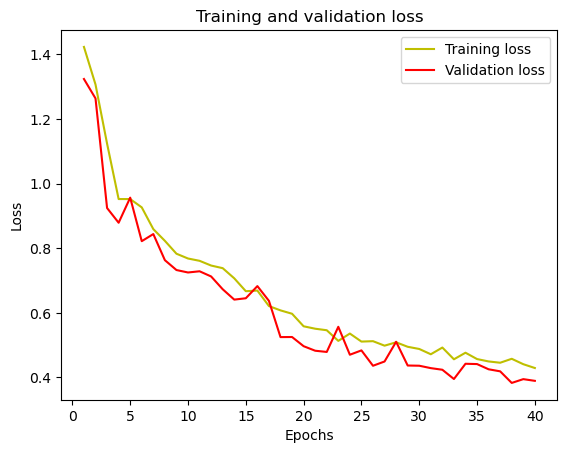

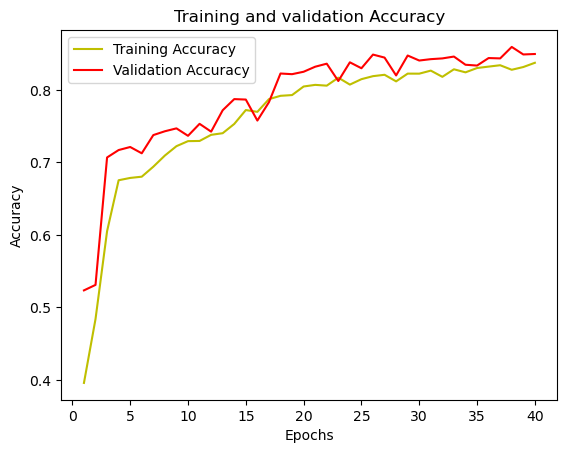

In [20]:
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
#model.load_weights('/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/z_tryout/Model2_random_floss.keras')  

In [21]:
##################################
model = get_model()
model.load_weights('/Users/pbecerra/CAS/ADS_course/Module6/project/image_data/z_tryout/Model4_random_catXent.keras')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Mean IoU = 0.47690576


In [22]:
from keras.metrics import IoU

In [24]:
#To calculate I0U for each class...

#values = np.array(IOU_keras.add_weight()).reshape(n_classes, n_classes)
#values = np.array(IOU_keras).reshape(n_classes, n_classes)
#print(values)

In [23]:
iou_class = []
for i in range(n_classes):
    m = IoU(num_classes=n_classes, target_class_ids=[i])
    m.update_state(y_test[:,:,:,0], y_pred_argmax)
    iou_class.append(m.result())
    
    print(f'iou of class  {i} is:',m.result().numpy())

iou of class  0 is: 0.88013494
iou of class  1 is: 0.60002774
iou of class  2 is: 0.0
iou of class  3 is: 0.025033858
iou of class  4 is: 0.87933207


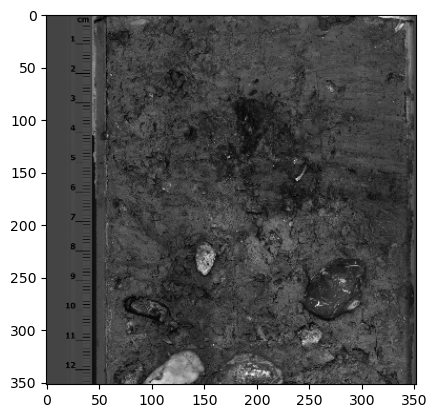

In [24]:
#class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
#class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
#class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
#class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

#print("IoU for class1 is: ", class1_IoU)
#print("IoU for class2 is: ", class2_IoU)
#print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0,:,:], cmap='gray')

In [25]:
train_images.shape, train_masks.shape
filename = files_dir[0]
print("Filename:", filename)

Filename: BASA1_003_1_A_0_mask.tif


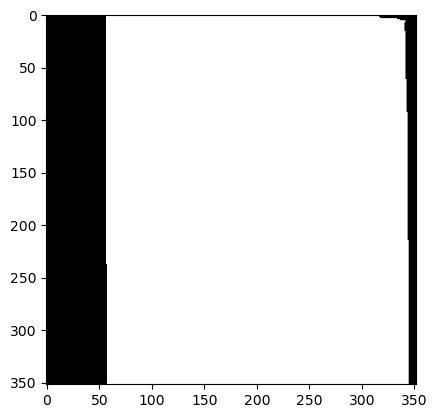

In [26]:
plt.imshow(train_masks[0,:,:], cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


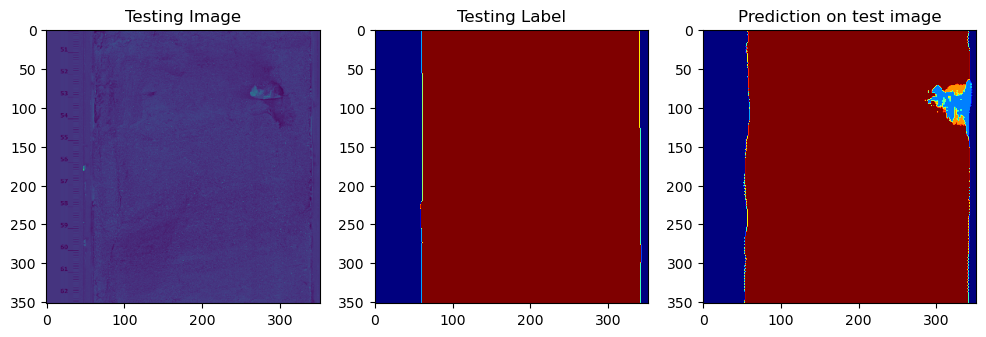

In [27]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = 40#random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])#, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

#####################################################################

#Predict on large image

#Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('large_images/large_image.tif', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()